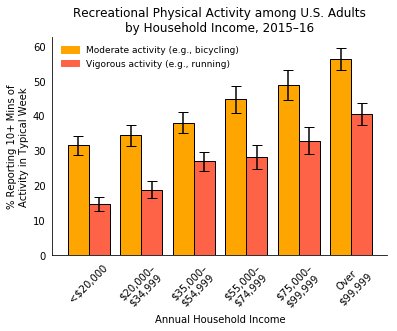

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#read in datasets
demo = pd.read_sas('DEMO_I.XPT')
pa201516 = pd.read_sas('PAQ_I.XPT')

#join some datasets
pademo = pd.merge(pa201516,demo,left_on='SEQN', right_on='SEQN')

#restrict data to only adults 18+
pademo = pademo[pademo['RIDAGEYR']>=18]

#recode physical activity questions PAQ 650 and PAQ 665
pademo['PAQ650'] = pademo['PAQ650'].map({1:1,2:0})
pademo['PAQ665'] = pademo['PAQ665'].map({1:1,2:0})

#narrow down to key data
keydata = pd.concat((pademo['SEQN'], pademo['INDHHIN2'], pademo['PAQ650'], pademo['PAQ665']), axis=1)

#recode household income values, condensing into 6 categories and excluding missing data, refused, don't know, and
#the under $20,000 and $20,000 and over categories (figured out by proxy only when interviewee refused to give dollar figure)
incbracketdict = {1:'<$20,000', 2:'<$20,000', 3:'<$20,000', 4:'<$20,000', 5:'\$20,000–$34,999',
                  6:'\$20,000–$34,999', 7:'\$35,000–$54,999', 8:'\$35,000–$54,999', 9:'\$55,000–$74,999',
                  10:'\$55,000–$74,999',
                  14:'\$75,000–$99,999', 15:'Over $99,999'}
keydata['INDHHIN2'] = keydata['INDHHIN2'].map(incbracketdict) 

#drop missing data
keydata = keydata.dropna()

#group by income bracket
keydatag = keydata.groupby(keydata['INDHHIN2'])

#get means for each income bracket
keydatameans = keydatag.mean()

#add a Count column and convert to percentages
keydatameans['Count'] = keydata.groupby(keydata['INDHHIN2']).size()
keydatameans['PAQ650 %'] = 100*keydatameans['PAQ650']
keydatameans['PAQ665 %'] = 100*keydatameans['PAQ665']

#get 95% CI for binomial distribution
keydatameans['Vigor CI 1/2 width'] = 1.96*((keydatameans['PAQ650 %']*(100-keydatameans['PAQ650 %'])/keydatameans['Count'])**0.5)
keydatameans['Vigor 95% CI Lower'] = keydatameans['PAQ650 %']-keydatameans['Vigor CI 1/2 width']
keydatameans['Vigor 95% CI Upper'] = keydatameans['PAQ650 %']+keydatameans['Vigor CI 1/2 width']
keydatameans['Moderate CI 1/2 width'] = 1.96*((keydatameans['PAQ665 %']*(100-keydatameans['PAQ665 %'])/keydatameans['Count'])**0.5)
keydatameans['Moderate 95% CI Lower'] = keydatameans['PAQ665 %']-keydatameans['Moderate CI 1/2 width']
keydatameans['Moderate 95% CI Upper'] = keydatameans['PAQ665 %']+keydatameans['Moderate CI 1/2 width']
keydatameans = keydatameans.reset_index()
keydatameans = keydatameans.reindex([0,2,3,4,5,1])
keydatameans = keydatameans.reset_index()

#setup for visual
index = np.arange(6)
hh2 = np.arange(len(keydatameans['INDHHIN2']))
incomecatorder = ['<$20,000','\$20,000–\n$34,999','\$35,000–\n$54,999', '\$55,000–\n$74,999','\$75,000–\n$99,999', 'Over\n$99,999']

#create the visual
plt.bar(index-0.2, keydatameans['PAQ665 %'], width=0.4, yerr=keydatameans['Moderate CI 1/2 width'],
        capsize=5, color='orange', edgecolor='k')
plt.bar(index+0.2, keydatameans['PAQ650 %'], width=0.4, yerr=keydatameans['Vigor CI 1/2 width'],
        capsize=5, color='tomato', edgecolor='k')
ax=plt.gca()

#turn off right and top walls of frame
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#set x-axis ticks, get rid of tick marks on axes, and rotate x-axis tick labels 45 degrees
plt.xticks(hh2, keydatameans['INDHHIN2'])
ax.set_xticklabels(incomecatorder)
ax.tick_params(axis='both', bottom=False, left=False)
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(45)

#set axis titles and chart title
plt.xlabel('Annual Household Income')
plt.ylabel('% Reporting 10+ Mins of\nActivity in Typical Week')
plt.title('Recreational Physical Activity among U.S. Adults\nby Household Income, 2015–16')

#make proxy artists for legend
import matplotlib.patches as mpatches
orange_patch = mpatches.Patch(color='orange', label='Moderate activity (e.g., bicycling)')
red_patch = mpatches.Patch(color='tomato', label='Vigorous activity (e.g., running)')
plt.legend(handles=[orange_patch, red_patch], fontsize=9, frameon=False)

#final product
plt.savefig('Matplotlib_Example_Visual',bbox_inches='tight')
plt.show()

In [8]:
#Dataframe to demonstrate that including the "Under $20,000" income bin (distinct from the 4 bins I aggregated to make the
#"<$20,000" bin) does not change results much

incbracketdictalt = {1:'<$20,000', 2:'<$20,000', 3:'<$20,000', 4:'<$20,000', 5:'\$20,000–$34,999',
                  6:'\$20,000–$34,999', 7:'\$35,000–$54,999', 8:'\$35,000–$54,999', 9:'\$55,000–$74,999',
                  10:'\$55,000–$74,999', 13:'<$20,000',
                  14:'\$75,000–$99,999', 15:'Over $99,999'}

#narrow down to key data
pademoadults2 = pademo.copy(deep=True)

#map income bracket labels to dataframe
pademoadults2['INDHHIN2'] = pademoadults2['INDHHIN2'].map(incbracketdictalt) 

#narrow to key data
keydata_alt = pd.concat((pademoadults2['SEQN'], pademoadults2['INDHHIN2'],
                         pademoadults2['PAQ650'], pademoadults2['PAQ665']), axis=1)

#drop missing data
keydata_alt454 = keydata_alt.dropna()

#group by income bracket
keydata_altg = keydata_alt454.groupby(keydata_alt['INDHHIN2'])

#get means for each income bracket
keydata_altmeans = keydata_altg.mean()

#add a Count column
keydata_altmeans['Count'] = keydata_alt.groupby(keydata_alt['INDHHIN2']).size()
keydata_altmeans['PAQ650 %'] = 100*keydata_altmeans['PAQ650']
keydata_altmeans['PAQ665 %'] = 100*keydata_altmeans['PAQ665']

#get 95% CI for binomial distribution
keydata_altmeans['Vigor CI 1/2 width'] = 1.96*((keydata_altmeans['PAQ650 %']*(100-keydata_altmeans['PAQ650 %'])/
                                            keydata_altmeans['Count'])**0.5)
keydata_altmeans['Vigor 95% CI Lower'] = keydata_altmeans['PAQ650 %']-keydata_altmeans['Vigor CI 1/2 width']
keydata_altmeans['Vigor 95% CI Upper'] = keydata_altmeans['PAQ650 %']+keydata_altmeans['Vigor CI 1/2 width']
keydata_altmeans['Moderate CI 1/2 width'] = 1.96*((keydata_altmeans['PAQ665 %']*(100-keydata_altmeans['PAQ665 %'])/
                                                  keydata_altmeans['Count'])**0.5)
keydata_altmeans['Moderate 95% CI Lower'] = keydata_altmeans['PAQ665 %']-keydata_altmeans['Moderate CI 1/2 width']
keydata_altmeans['Moderate 95% CI Upper'] = keydata_altmeans['PAQ665 %']+keydata_altmeans['Moderate CI 1/2 width']

#put income brackets in logical order
keydata_altmeans = keydata_altmeans.reset_index()
keydata_altmeans = keydata_altmeans.reindex([0,2,3,4,5,1])
keydata_altmeans = keydata_altmeans.reset_index()

#final dataframe
print('"Results with "Under $20,000" assimilated dataframe')
print(keydata_altmeans)

"Results with "Under $20,000" assimilated dataframe
   index          INDHHIN2          SEQN    PAQ650    PAQ665  Count  \
0      0          <$20,000  88831.331641  0.146362  0.308799   1183   
1      2  \$20,000–$34,999  88605.961145  0.187117  0.343558    981   
2      3  \$35,000–$54,999  88647.456670  0.268744  0.379747   1028   
3      4  \$55,000–$74,999  88470.157651  0.281298  0.446677    647   
4      5  \$75,000–$99,999  88836.943119  0.328440  0.488073    545   
5      1      Over $99,999  88776.313089  0.404188  0.563351    955   

    PAQ650 %   PAQ665 %  Vigor CI 1/2 width  Vigor 95% CI Lower  \
0  14.636210  30.879865            2.014257           12.621953   
1  18.711656  34.355828            2.440573           16.271083   
2  26.874391  37.974684            2.709964           24.164427   
3  28.129830  44.667697            3.464670           24.665160   
4  32.844037  48.807339            3.943015           28.901022   
5  40.418848  56.335079            3.112439     

In [9]:
#Dataframe to demonstrate that standard deviations of two possible alternative metrics, days and minutes
#of recreational physical activity, are extremely high and the confidence intervals wide enough to
#extend far into the negatives, making days and minutes unfit metrics.

#make unliked copy of pademoadults
pademo3 = pademo.copy(deep=True)

#restrict data to only adults 18+
pademoadults3 = pademo3[pademo3['RIDAGEYR']>=18]


#recode physical activity questions PAQ 650 and PAQ 665
pademoadults3['PAQ650'] = pademoadults3['PAQ650'].map({1:1,2:0})
pademoadults3['PAQ665'] = pademoadults3['PAQ665'].map({1:1,2:0})

pademoadults3['INDHHIN2'] = pademoadults3['INDHHIN2'].map(incbracketdict) 

#replace missing values for days and minutes with 0 if the answer to PAQ 650 (at least 10 minutes of vigorous activity in
#a typical week) is No (rather than Missing), or if the answer to PAQ 665 (same as PAQ 650, but for moderate activity) is No
pademoadults3['PAQ655'] = pademoadults3.apply(lambda x: 0 if x['PAQ650']==0 else x['PAQ655'],axis=1)
pademoadults3['PAD660'] = pademoadults3.apply(lambda x: 0 if x['PAQ655']==0 else x['PAD660'],axis=1)
pademoadults3['PAQ670'] = pademoadults3.apply(lambda x: 0 if x['PAQ665']==0 else x['PAQ670'],axis=1)
pademoadults3['PAD675'] = pademoadults3.apply(lambda x: 0 if x['PAQ670']==0 else x['PAD675'],axis=1)

#narrow dataframe to key data (now includes days and minutes for both types of activity)
keydata_alt2 = pd.concat((pademoadults3['SEQN'], pademoadults3['INDHHIN2'], pademoadults3['PAQ650'],
                        pademoadults3['PAQ655'],pademoadults3['PAD660'], pademoadults3['PAQ665'], pademoadults3['PAQ670'],
                       pademoadults3['PAD675']), axis=1)

#drop missing data
keydata_alt2b = keydata_alt2.dropna()

#group by income bracket
keydata_alt2g = keydata_alt2b.groupby(keydata_alt2['INDHHIN2'])

#get means for each income bracket
keydata_alt2means = keydata_alt2g.mean()

#add a Count column
keydata_alt2means['Count'] = keydata_alt2.groupby(keydata_alt2['INDHHIN2']).size()

#set up confidence intervals
keydatastd = keydata_alt2.groupby(keydata_alt2['INDHHIN2']).agg(np.std, ddof=1)
keydata_alt2means['Vigor Days CI 1/2 width'] = 1.96*keydatastd['PAQ655']
keydata_alt2means['Vigor Days 95% CI Lower'] = keydata_alt2means['PAQ655']-keydata_alt2means['Vigor Days CI 1/2 width']
keydata_alt2means['Vigor Days 95% CI Upper'] = keydata_alt2means['PAQ655']+keydata_alt2means['Vigor Days CI 1/2 width']

keydata_alt2means['Moderate Days CI 1/2 width'] = 1.96*keydatastd['PAQ670']
keydata_alt2means['Moderate Days 95% CI Lower'] = keydata_alt2means['PAQ670']-keydata_alt2means['Moderate Days CI 1/2 width']
keydata_alt2means['Moderate Days 95% CI Upper'] = keydata_alt2means['PAQ670']+keydata_alt2means['Moderate Days CI 1/2 width']

keydata_alt2means['Vigor Minutes CI 1/2 width'] = 1.96*keydatastd['PAD660']
keydata_alt2means['Vigor Minutes 95% CI Lower'] = keydata_alt2means['PAD660']-keydata_alt2means['Vigor Minutes CI 1/2 width']
keydata_alt2means['Vigor Minutes 95% CI Upper'] = keydata_alt2means['PAD660']+keydata_alt2means['Vigor Minutes CI 1/2 width']

keydata_alt2means['Moderate Minutes CI 1/2 width'] = 1.96*keydatastd['PAD675']
keydata_alt2means['Moderate Minutes 95% CI Lower'] = keydata_alt2means['PAD675']-keydata_alt2means['Moderate Minutes CI 1/2 width']
keydata_alt2means['Moderate Minutes 95% CI Upper'] = keydata_alt2means['PAD675']+keydata_alt2means['Moderate Minutes CI 1/2 width']

#put income brackets in logical order
keydata_alt2means = keydata_alt2means.reset_index()
keydata_alt2means = keydata_alt2means.reindex([0,2,3,4,5,1])
keydata_alt2means = keydata_alt2means.reset_index()

#final dataframe (note the confidence intervals)
print('Alternate Metrics Dataframe (last 14 columns)')
print(keydata_alt2means.iloc[:,-14:])

Alternate Metrics Dataframe (last 14 columns)
       PAD675  Count  Vigor Days CI 1/2 width  Vigor Days 95% CI Lower  \
0   75.346535   1088                 3.526888                 0.225587   
1  147.606061    981                 3.022243                 0.121696   
2   61.954545   1028                 2.956729                 0.253498   
3   61.168000    647                 3.034579                 0.469421   
4   60.571429    545                 2.919433                 0.342472   
5   60.090909    955                 3.045434                 0.318202   

   Vigor Days 95% CI Upper  Moderate Days CI 1/2 width  \
0                 7.279364                   10.759005   
1                 6.166183                    3.481141   
2                 6.166956                    3.495392   
3                 6.538579                    3.263189   
4                 6.181338                    3.324729   
5                 6.409070                    3.444921   

   Moderate Days 95% CI Lowe